In [2]:
import importlib
from tqdm import tqdm
import neurokit2 as nk
sys.path.append('../signal_quality/')
import datasets
import sqis
import ecg_featurization
importlib.reload(datasets)
importlib.reload(sqis)
importlib.reload(ecg_featurization)

x_list = []
y_list = []
data = datasets.load_picc(verbose=False)
for subject in tqdm(data.keys()):
    for channel in data[subject].keys():
    ## Remove baseline wader and dc offset with highpass Butterworth.
    #     clean = signal_filter(signal=ecg_signal, sampling_rate=sampling_rate, lowcut=0.5, method="butterworth", order=5)
    ## remove powerline interference
    #     clean = signal_filter(signal=clean, sampling_rate=sampling_rate, method="powerline", powerline=50)

        ecg_cleaned = nk.ecg_clean(data[subject][channel]['data'], sampling_rate=125, method="neurokit")

        kSQI = sqis.k_SQI(ecg_cleaned, kurtosis_method='fisher')
        pSQI = sqis.p_SQI(ecg_cleaned, sampling_rate=125, window=len(ecg_cleaned)//125)
        basSQI = sqis.bas_SQI(ecg_cleaned, sampling_rate=125, window=len(ecg_cleaned)//125)
        averageQRS_SQI = sqis.averageQRS_SQI(ecg_cleaned, sampling_rate=125)
        zhao2018_SQI = sqis.zhao2018_SQI(ecg_cleaned, sampling_rate=125)
        orphanidou2015_sqi = sqis.orphanidou2015_sqi(ecg_window=ecg_cleaned, sampling_rate=125)
        ecg_features_list = ecg_featurization.featurize_windows(windows=[ecg_cleaned], sampling_rate=125, show=False)

        x_list.append([kSQI, pSQI, basSQI, averageQRS_SQI, zhao2018_SQI, orphanidou2015_sqi]+ecg_features_list)
        y_list.append(data[subject][channel]['labels'])


277it [00:01, 240.48it/s]

(8023, 6) (3953, 6)


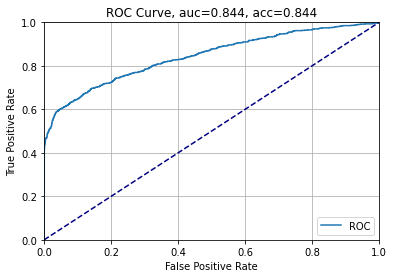

In [ ]:
import numpy as np
import sklearn.ensemble
import matplotlib.pyplot as plt

x_list = np.array(x_list)
x_list = np.nan_to_num(x_list, nan=-1, posinf=-1, neginf=-1)
y_list = np.array(y_list).flatten()

model = sklearn.ensemble.RandomForestClassifier(random_state=0, n_estimators=1000, max_depth=5)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(x_list, y_list, test_size=0.33, random_state=0)
print(X_train.shape, X_test.shape)
model.fit(X_train, y_train)

scores = model.predict_proba(X_test)[:,1]
acc = np.mean(model.predict(X_test)==y_test)
auc = sklearn.metrics.roc_auc_score(y_test, scores)
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, scores, pos_label=1)
plt.plot(fpr, tpr, label='ROC')
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve, auc={0:0.3f}, acc={0:0.3f}".format(auc, acc))
plt.legend(loc="lower right"); plt.grid()